In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

In [3]:


class Net(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        super(Net, self).__init__()
        layers = []
        prev_size = input_size
        for size in hidden_layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        layers.append(nn.Linear(prev_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

import matplotlib.pyplot as plt

def build_and_train_model(train_loader, val_loader, test_loader,
                          input_size=784, hidden_layer_sizes=[512, 512],
                          activation_function=nn.ReLU(), output_size=10, 
                          optimizer_cls=optim.Adam, loss_function=nn.CrossEntropyLoss(),
                          lr=0.001, epochs=10):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net(input_size, hidden_layer_sizes, output_size).to(device)
    optimizer = optimizer_cls(model.parameters(), lr=lr)

    # Lists to store values for each epoch
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_accuracy = evaluate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    test_accuracy = evaluate(model, test_loader, device)
    print(f'\nTest Accuracy: {test_accuracy:.2f}%')
    
    return model, train_losses, val_accuracies

def plot_training(train_losses, val_accuracies):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()



In [11]:


# Load MNIST Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:


# Use the functions
model, train_losses, val_accuracies = build_and_train_model(train_loader, val_loader, test_loader, epochs= 10, hidden_layer_sizes = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512])
plot_training(train_losses, val_accuracies)


In [12]:
# Save model's state_dict
path = "./mnist_model.pth"
torch.save(model.state_dict(), path)

print(f"Model saved at {path}")


Model saved at ./mnist_model_6.pth


code to load the model  

# Initialize a model
loaded_model = Net(input_size=784, hidden_layer_sizes=[512, 512], output_size=10)
loaded_model.load_state_dict(torch.load(path))
loaded_model.eval()  # Set to evaluation mode

# If you're using a GPU:
# loaded_model = loaded_model.to('cuda')


In [7]:
# Initialize a model
path = "./mnist_model.pth"
model = Net(input_size=784, hidden_layer_sizes=[512, 512], output_size=10)
model.load_state_dict(torch.load(path))
model.eval()  # Set to evaluation mode

# If you're using a GPU:
# loaded_model = loaded_model.to('cuda')

Net(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [17]:
model = Net(input_size=784, hidden_layer_sizes=[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512], output_size=10)

In [18]:
device = 'cpu'

# Define a hook to collect activations
activations = {}

def hook_fn(module, input, output, key):
    activations[key] = output

# Register the hook for each layer
for name, layer in model.named_modules():
    layer.register_forward_hook(lambda module, input, output, key=name: hook_fn(module, input, output, key))

# Run inference on the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)

# Calculate and print variance for each layer's activations
variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

for layer_name, variance in variances.items():
    print(f"Layer {layer_name} - Variance: {variance.mean().item()}")


Layer layers.0 - Variance: 0.09324231743812561
Layer layers.1 - Variance: 0.03742697834968567
Layer layers.2 - Variance: 0.012257643975317478
Layer layers.3 - Variance: 0.005100490525364876
Layer layers.4 - Variance: 0.0016721055144444108
Layer layers.5 - Variance: 0.0007392683764919639
Layer layers.6 - Variance: 0.00025693108909763396
Layer layers.7 - Variance: 0.0001189919130410999
Layer layers.8 - Variance: 3.9729005948174745e-05
Layer layers.9 - Variance: 1.8318838556297123e-05
Layer layers.10 - Variance: 6.111457878432702e-06
Layer layers.11 - Variance: 2.9667444323422387e-06
Layer layers.12 - Variance: 1.0033741091319826e-06
Layer layers.13 - Variance: 5.18944148097944e-07
Layer layers.14 - Variance: 1.6694031046426971e-07
Layer layers.15 - Variance: 8.098972159586992e-08
Layer layers.16 - Variance: 2.6199185043651596e-08
Layer layers.17 - Variance: 1.275302263792355e-08
Layer layers.18 - Variance: 4.16048351326026e-09
Layer layers.19 - Variance: 2.13068185317411e-09
Layer layers

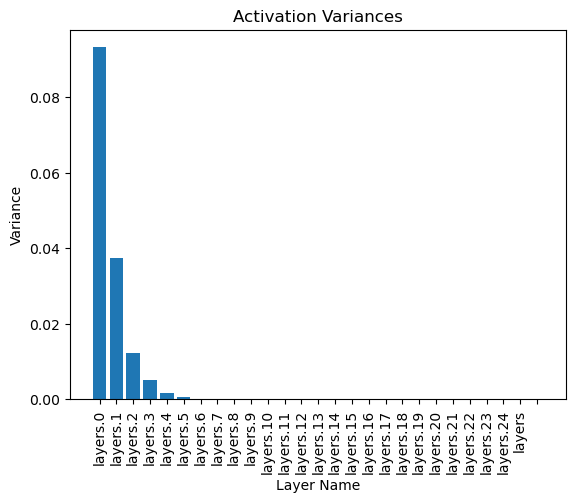

In [19]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.bar(layer_names, variance_values)
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()